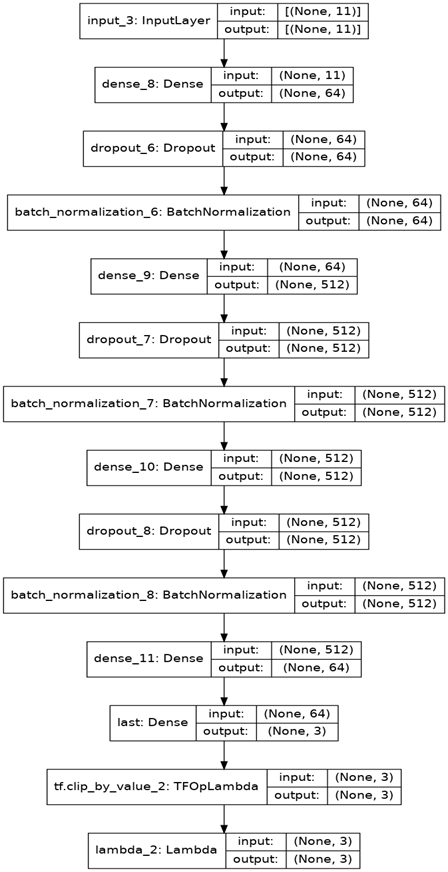

<h2>We increase the dimension to 512 neurons and then reduce it for convergence<h2>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import math

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.models import Model


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jul-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv")
minmax = MinMaxScaler()

<h2> Outliers hunting

In [ ]:
train = train[(train['target_nitrogen_oxides'] <1100) & (train['target_nitrogen_oxides'] > 10) == True]
print("NEW TRAIN SIZE : ")
len(train[(train['target_nitrogen_oxides'] < 1100 ) & (train['target_nitrogen_oxides']>10) == True])

In [ ]:
train = train[train['target_carbon_monoxide'] < 8.5 ]
print("NEW TRAIN SIZE : ")
len(train[train['target_carbon_monoxide'] < 8.5])

In [ ]:
train = train[train['target_benzene'] < 40]
print("NEW TRAIN SIZE : ")
len(train[(train['target_benzene'] < 40)])


<h2> Features augmentation

In [ ]:
train['date_time'] = train['date_time'].astype('datetime64[ns]')
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['weekday'] = train['date_time'].dt.dayofweek
train["working_hours"] =  train["hour"].isin(np.arange(8, 21, 1)).astype("int")
train["weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")

In [ ]:
test['date_time'] = test['date_time'].astype('datetime64[ns]')
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.dayofweek
test["working_hours"] =  test["hour"].isin(np.arange(8, 21, 1)).astype("int")
test["weekend"] = (test["date_time"].dt.dayofweek >= 5).astype("int")

In [ ]:
train = train[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5',
                'target_carbon_monoxide',
                'target_benzene',
                'target_nitrogen_oxides'
                 ]]

In [ ]:
test = test[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5'
                 ]]

<h2> Features rescaling

In [ ]:
#train all targets
train_df = train.iloc[:,1:-3]
test_df = test.iloc[:,1:]
all_df = pd.concat([train_df,test_df], axis = 0)
all_df = pd.DataFrame(minmax.fit_transform(all_df))
train_sc = all_df.iloc[:len(train),:]
test_sc = all_df.iloc[len(train):,:]
y_sc = train.iloc[:,-3:]
train_sc.shape,test_sc.shape,y_sc.shape

<h2> Loss and metric functions for NN

In [ ]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mse = tf.keras.losses.MeanSquaredError()

es = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-12, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=2, verbose=0,
    mode='auto')

<h2> Internal updates of the NN (unused)

In [ ]:
# Not used
def rectifier(x):
    #x = tf.math.log(x)
    x = x
    return x


<h2> Model definition

In [ ]:
def reg_model():

    reg_inputs = layers.Input(shape = (13))
   
    x = layers.Dense(
            units = 32, 
            activation ='relu',
            kernel_initializer ='he_uniform')(reg_inputs)
    
    x = layers.Dense(
            units = 256, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)
    
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
            units = 512, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)

    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
            units = 256, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)

    x = layers.Dense(
            units = 32, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)
        
    x = layers.Dense(
            units = 3,
        activation = 'linear',
        kernel_initializer ='he_uniform',name = 'last')(x)
    
    #x = tf.keras.backend.clip(x, 0.1,1100)
    
    reg_outputs = layers.Lambda(rectifier)(x)

    #----------- Model instantiation  ---------------
    model = Model(reg_inputs,reg_outputs)

    return model

In [ ]:
split = 0.025
ind_tr = np.round(len(train_sc)*(1-split),0).astype('int')
X_train = train_sc.iloc[:ind_tr,:]
y_train = y_sc.iloc[:ind_tr]
X_test = train_sc.iloc[ind_tr:,:]
y_test = y_sc.iloc[ind_tr:]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
y_train_log = y_train.copy()
y_test_log = y_test.copy()
y_train_log.iloc[:,0] = y_train.iloc[:,0].map(lambda x : math.log(x+1))
y_train_log.iloc[:,1] = y_train.iloc[:,1].map(lambda x : math.log(x+1))
y_train_log.iloc[:,2] = y_train.iloc[:,2].map(lambda x : math.log(x+1))
y_test_log.iloc[:,0] = y_test.iloc[:,0].map(lambda x : math.log(x+1))
y_test_log.iloc[:,1] = y_test.iloc[:,1].map(lambda x : math.log(x+1))
y_test_log.iloc[:,2] = y_test.iloc[:,2].map(lambda x : math.log(x+1))

<h2> Benchmark preparation before training and submission (no blending)

In [ ]:
"""
from Somayyeh Gholami & Mehran Kazeminia, smart ensembling based upon :
Thanks to: @paddykb https://www.kaggle.com/paddykb/tps-07-gam-baseline
Thanks to: @junhyeok99 https://www.kaggle.com/junhyeok99/automl-pycaret
"""
bench = pd.read_csv("../input/benchmark1/submission.csv")
bench = bench.iloc[:,1:]
bench_stat = bench.describe()

<h2> Training and best prediction choice

In [ ]:
ROUND = 50 # Several iterations because of the stochastic calculation
pred_final = np.zeros((len(test_sc),3))
print('======== TRAINING STARTING ============\n')
approved = 0

for i in range(ROUND):
    model = reg_model()
    model.compile(loss=msle,optimizer = keras.optimizers.Adam())
    model.fit(X_train,y_train_log,
              batch_size = 64, 
              epochs = 100,
              validation_data=(X_test,y_test_log),
              callbacks=[es, plateau],
              verbose =0)
    pred = model.predict(X_test)
    pred[:,0] = np.exp(pred[:,0])-1
    pred[:,1] = np.exp(pred[:,1])-1
    pred[:,2] = np.exp(pred[:,2])-1
    pred = np.where(pred>0,pred,0)
    
    score = mean_squared_log_error(y_test, pred)
    print(f"Score for round {i} on X_test :", score)
    pred_all = model.predict(train_sc)
    pred_all[:,0] = np.exp(pred_all[:,0])-1
    pred_all[:,1] = np.exp(pred_all[:,1])-1
    pred_all[:,2] = np.exp(pred_all[:,2])-1
    pred_all = np.where(pred_all>0.01,pred_all,0.01)
    score_all = mean_squared_log_error(y_sc, pred_all)
    print(f"Score for round {i} on all dataset :", score_all)
    
    # In case of multiple iterations, we can reject anomalous predictions :
    if (score < 0.15) == True:
        approved += 1
        print(f"round {i} approved for benchmarking analysis ")
        pred_test = model.predict(test_sc)
        pred_test[:,0] = np.exp(pred_test[:,0])-1
        pred_test[:,1] = np.exp(pred_test[:,1])-1
        pred_test[:,2] = np.exp(pred_test[:,2])-1
        pred_test = np.where(pred_test>0,pred_test,0.05)
        
        pred_test[:,0] = np.where(pred_test[:,0]<9.5,pred_test[:,0],9.5)
        pred_test[:,0] = np.where(pred_test[:,0]>0.24,pred_test[:,0],0.24)

        pred_test[:,1] = np.where(pred_test[:,1]< 45,pred_test[:,1],45)
        
        pred_test[:,2] = np.where(pred_test[:,2]< 1100,pred_test[:,2],1100)
        pred_test[:,2] = np.where(pred_test[:,2]> 24,pred_test[:,2],24)
            
        # Run analysis :
        df = pd.concat([pd.DataFrame(pred_test).describe(),pd.DataFrame(bench_stat)], axis = 1)
        
        carbon_75 = np.abs((df.iloc[6,0]-df.iloc[6,3])/df.iloc[6,3])
        benzene_75 = np.abs((df.iloc[6,1]-df.iloc[6,4])/df.iloc[6,4])
        nitrogen_75 = np.abs((df.iloc[6,2]-df.iloc[6,5])/df.iloc[6,5])
        
        carbon_50 = np.abs((df.iloc[5,0]-df.iloc[5,3])/df.iloc[5,3])
        benzene_50 = np.abs((df.iloc[5,1]-df.iloc[5,4])/df.iloc[5,4])
        nitrogen_50 = np.abs((df.iloc[5,2]-df.iloc[5,5])/df.iloc[5,5])
        
        carbon_25 = np.abs((df.iloc[4,0]-df.iloc[4,3])/df.iloc[4,3])
        benzene_25 = np.abs((df.iloc[4,1]-df.iloc[4,4])/df.iloc[4,4])
        nitrogen_25 = np.abs((df.iloc[4,2]-df.iloc[4,5])/df.iloc[4,5])
        
        run_75 =100 *(carbon_75 + benzene_75 + nitrogen_75)/3
        run_50 =100 *(carbon_50 + benzene_50 + nitrogen_50)/3
        run_25 =100 *(carbon_25 + benzene_25 + nitrogen_25)/3
        
        print('GAP WITH BENCHMARK :',run_75,run_50,run_25,'%\n')
        if ((run_75 < 3) & (run_50 < 5) & (run_25 < 6))== True :
            pred_final += pred_test
            print("PREDICTION RECORDED")
            print(f"GAP 75% :{run_75} GAP 50% :{run_50} GAP 25% :{run_25}")
            break
        else :
            print('PREDICTION REJECTED \n')
    else :
        print(f"round {i} rejected \n")

    
print(f"\n====== End of the training :{approved} accepted rounds for this training =====\n")

<h2> Benchmark analysis (no blending)

In [ ]:
print("=================== NEURAL NETWORK ===================== ")
bench_pred = pd.DataFrame(pred_final, columns = ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'])
display(bench_pred.head(5))
print("===================== BENCHMARK ======================== ")
display(bench.head(5).astype('float32'))

In [ ]:
print("================= NEURAL NETWORK STATISTIC =================")
display(bench_pred.describe())
print("=================== BENCHMARK STATISTIC ===================")
display(bench.describe())

In [ ]:
sample_submission['target_carbon_monoxide'] = pred_final[:,-3]
sample_submission['target_benzene'] = pred_final[:,-2]
sample_submission['target_nitrogen_oxides'] = pred_final[:,-1]

In [ ]:
sample_submission.to_csv('sub_NN16.csv',index = False)